In [1]:
import pandas as pd
import regex as re

from sklearn.model_selection import train_test_split

import ahocorasick

import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer, MT5ForConditionalGeneration, get_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW, lr_scheduler

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
SEP_TOKEN = '▁<extra_id_0>'
INPUT_PREFIX = ''

In [3]:
df = pd.read_json ('train_t1_v1.jsonl', lines = True)
df.drop (columns = ['id', 'keywords'], inplace = True)
print (df.head ())

                                                text  \
0  ABBYY Retrieval & Morphology Engine\nВ сообщен...   
1  Речевые формулы в диалоге\nПредложенная класси...   
2  Географические названия и полнотекстовые докум...   
3  Методы автоматического построения специализиро...   
4  Закономерности построения дискурсивной последо...   

                                               label  
0  [[0, 35], [6, 15], [18, 35], [29, 35], [69, 88...  
1  [[0, 15], [18, 25], [74, 99], [134, 140], [175...  
2  [[0, 23], [26, 50], [54, 68], [169, 190], [181...  
3  [[7, 63], [34, 63], [54, 63], [92, 128], [119,...  
4  [[26, 57], [62, 76], [251, 265], [266, 280], [...  


In [4]:
def split_text (text, segments, delimiters = ['...', '.', '?!', '?', '!']):

    # Фильтрация
    #text = re.sub ('[“”]', '\"', text)

    # Создаем регулярное выражение для разделителей
    delimiters_pattern = '|'.join (map (re.escape, delimiters))
    
    # Разделяем текст на абзацы
    #paragraphs = text.split ('\n')
    paragraphs = re.split (f'(?<=\n[ ]*)', text)
    
    # Список для хранения предложений и их индексов
    sentences_with_segments = []
    
    current_start_index = 0
    # Обрабатываем каждый абзац
    for paragraph in paragraphs:
        # Разделяем абзац на предложения
        sentences = re.split (f'(?<=[{delimiters_pattern}] )(?=[A-ZА-ЯЁ])', paragraph)#.strip ())

        #print (f'\nРассматривается параграф: <{paragraph}>.')
        
        # Сопоставляем предложения с сегментами
        for sentence in sentences:
            #print ('> Предложение:', sentence)
            # Ищем индексы символов для текущего предложения
            start_index = current_start_index
            end_index = start_index + len (sentence)

            #print (f'Current sentence (from split): <{sentence}>')
            #print (f'Current sentence (by indices): <{text [start_index: end_index]}>')
            #print (f'Sentence start index: {start_index}, end index: {end_index}.')
            #print (f'Segments to match: {segments}')

            matched_segments = [
                text [start: end] for start, end in segments if start >= start_index and end <= end_index
            ]
            sentences_with_segments.append ((sentence, matched_segments))

            #current_start_index += len (sentence) + MAGIC_NUMBER
            current_start_index = end_index


            #print ('Термины:', matched_segments)
    
    return sentences_with_segments

In [5]:
train_data_txt, temp_data_txt, train_labels_txt, temp_labels_txt = train_test_split (df ['text'], df ['label'], test_size = 0.2, random_state = 14)
val_data_txt, test_data_txt, val_labels_txt, test_labels_txt = train_test_split (temp_data_txt, temp_labels_txt, test_size = 0.5, random_state = 14)

In [6]:
train_data_lst = train_data_txt.tolist ()
train_labels_lst = train_labels_txt.tolist ()

parallel_text = []
parallel_label = []

for i in range (len (train_data_lst)):
    text = train_data_lst [i]
    segments = train_labels_lst [i]
    splitted = split_text (text, segments)
    for sentence, terms in splitted:
        parallel_text.append (INPUT_PREFIX + sentence)
        constructed_label = ''
        for term in terms:
            constructed_label += term.strip () + SEP_TOKEN
        if len (constructed_label) > 0:
            parallel_label.append (constructed_label [: - len (SEP_TOKEN)])
        else:
            parallel_label.append ('')


val_data_lst = val_data_txt.tolist ()
val_labels_lst = val_labels_txt.tolist ()
parallel_text_val = []
parallel_label_val = []
for i in range (len (val_data_lst)):
    text = val_data_lst [i]
    segments = val_labels_lst [i]
    splitted = split_text (text, segments)
    for sentence, terms in splitted:
        parallel_text_val.append (INPUT_PREFIX + sentence)
        constructed_label = ''
        for term in terms:
            constructed_label += term.strip () + SEP_TOKEN
        if len (constructed_label) > 0:
            parallel_label_val.append (constructed_label [: - len (SEP_TOKEN)])
        else:
            parallel_label_val.append ('')


test_data_lst = test_data_txt.tolist ()
test_labels_lst = test_labels_txt.tolist ()
parallel_text_test = []
parallel_label_test = []
for i in range (len (test_data_lst)):
    text = test_data_lst [i]
    segments = test_labels_lst [i]
    splitted = split_text (text, segments)
    for sentence, terms in splitted:
        parallel_text_test.append (INPUT_PREFIX + sentence)
        constructed_label = ''
        for term in terms:
            constructed_label += term.strip () + SEP_TOKEN
        if len (constructed_label) > 0:
            parallel_label_test.append (constructed_label [: - len (SEP_TOKEN)])
        else:
            parallel_label_test.append ('')

In [7]:
USED_MODEL_NAME = 'cointegrated/rut5-small'

SEQ_MAX_LENGTH = 150
BATCH_SIZE = 8
EVAL_BATCH_SIZE = 20

In [8]:
tokenizer = AutoTokenizer.from_pretrained (USED_MODEL_NAME)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
c:\Users\Enfi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [9]:
train_data = tokenizer (parallel_text, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
train_labels = tokenizer (parallel_label, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')

val_data = tokenizer (parallel_text_val, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (parallel_label_val, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')

test_data = tokenizer (parallel_text_test, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
test_labels = tokenizer (parallel_label_test, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')

In [10]:
### EXPERIMENTAL SOMETHING

def replace_padding (labels):
    for i in range (0, len (labels ['input_ids'])):
        labels ['input_ids'] [i] = torch.tensor ([labl if labl != 0 else - 100 for labl in labels ['input_ids'] [i]])

    return labels

rse = replace_padding (train_labels)
train_labels = rse

rse = replace_padding (val_labels)
val_labels = rse

rse = replace_padding (test_labels)
test_labels = rse

rse ['input_ids']
###

tensor([[14539,  7870,  6507,  ...,  -100,  -100,  -100],
        [ 7788,  6252,  1609,  ...,  -100,  -100,  -100],
        [ 8427,   324,   259,  ...,  -100,  -100,  -100],
        ...,
        [  259, 11749, 14078,  ...,  -100,  -100,  -100],
        [  401, 13839, 17069,  ...,  -100,  -100,  -100],
        [  259, 19330, 10686,  ...,  -100,  -100,  -100]])

In [11]:
class Seq2SeqDataset (Dataset):
    def __init__ (self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__ (self, idx):
        return {
            'input_ids': self.encodings ['input_ids'] [idx],
            'attention_mask': self.encodings ['attention_mask'] [idx],
            'labels': self.labels ['input_ids'] [idx]
        }

    def __len__ (self):
        return len (self.encodings ['input_ids'])

train_dataset = Seq2SeqDataset (train_data, train_labels)
val_dataset = Seq2SeqDataset (val_data, val_labels)
test_dataset = Seq2SeqDataset (test_data, test_labels)

train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)
test_loader = DataLoader (test_dataset, batch_size = EVAL_BATCH_SIZE)

In [12]:
device = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')

model = MT5ForConditionalGeneration.from_pretrained (USED_MODEL_NAME)

model.to (device)
print (model.device)
#model.train ()


cuda:0


In [13]:
def get_set (tensor, ground_truth = True, tokenizer = tokenizer):

    separator: str
    if SEP_TOKEN == '▁<extra_id_0>': separator = '<extra_id_0>'
    else: separator = SEP_TOKEN

    res: set

    if ground_truth:
        eos_idx = (tensor == 1).nonzero ()
        if eos_idx.numel () > 0:
            eos_idx = int (eos_idx [0] [0])
        else:
            eos_idx = len (tensor)
        seq = tensor [:eos_idx]
    
    else:
        seq = tensor [tensor != 0]
        seq = seq [seq != - 100]   ### WHAT?!
        seq = seq [seq != 1]
    
    txt = tokenizer.decode (seq)
    res = set ([item.strip () for item in txt.split (separator)])

    if len (res) > 1:
        res -= set ([''])

    return res


def sanity_check (preds, labels, to_print = False):

    tps_sum = 0
    fps_sum = 0
    fns_sum = 0 

    for i in range (len (labels)):
        predicted_set = get_set (preds [i], ground_truth = False)
        true_set = get_set (labels [i])

        if to_print: print (f'True: {true_set}\nPred: {predicted_set}')

        tps_sum += len (true_set & predicted_set)  # Истинно положительные
        fps_sum += len (predicted_set - true_set)     # Ложноположительные
        fns_sum += len (true_set - predicted_set)     # Ложноотрицательные

    precision = tps_sum / (tps_sum + fps_sum) if (tps_sum + fps_sum) > 0 else 0
    recall = tps_sum / (tps_sum + fns_sum) if (tps_sum + fns_sum) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [14]:
metrics = {'train_loss': [], 'val_loss': [], 'precision': [], 'recall': [], 'f1_score': []}

In [15]:
num_epochs = 75
training_steps = len (train_data ['input_ids']) // BATCH_SIZE * num_epochs
warmup_steps = int (training_steps * 0.1)
print (f'Suggested train steps: {training_steps}\n\t warmup steps: {int (training_steps * 0.05)} - {int (training_steps * 0.1)}')

Suggested train steps: 31350
	 warmup steps: 1567 - 3135


In [16]:
from fairseq.optim.adafactor import Adafactor

2025-05-13 15:23:37 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


In [17]:
#optimizer = AdamW (model.parameters (), lr = 1e-5)#, weight_decay = 0.05)
#optimizer = AdamW (filter (lambda p: p.requires_grad, model.parameters ()), lr = 1e-4, weight_decay = 0.01)

optimizer = Adafactor (model.parameters (), lr = 2e-5, scale_parameter = False, relative_step = False, weight_decay = 0.02)

#scheduler = lr_scheduler.StepLR (optimizer, warmup_steps = 637, training_steps = 6375)
scheduler = get_scheduler ('linear', optimizer = optimizer, num_warmup_steps = warmup_steps, num_training_steps = training_steps)

In [18]:
for epoch in range (num_epochs):
    model.train ()  # Устанавливаем модель в режим обучения
    total_loss = 0
    
    for batch in tqdm (train_loader):
        
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)

        outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs.loss   ## DOUBLE CHECK if padding ...
        total_loss += loss.item ()

        loss.backward ()  # Обратное распространение
        optimizer.step ()  # Обновление параметров
        optimizer.zero_grad ()  # Обнуляем градиенты

        scheduler.step ()  # Обновление learning rate
    

    avg_loss = total_loss / len (train_loader)

    metrics ['train_loss'].append ((epoch, avg_loss))

    # Оценка на валидационной выборке
    model.eval ()  # Устанавливаем модель в режим оценки
    val_preds, val_labels = [], []
    total_val_loss = 0

    with torch.no_grad ():
        for batch in val_loader:
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels = batch ['labels'].to (model.device)

            outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask)

            total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels).loss.item ()

            val_preds.extend (outputs)
            val_labels.extend (labels)

    avg_val_loss = total_val_loss / len (val_loader)

    prec, recl, f1sc = sanity_check (val_preds, val_labels)

    metrics ['val_loss'].append ((epoch, avg_val_loss))
    metrics ['precision'].append ((epoch, prec))
    metrics ['recall'].append ((epoch, recl))
    metrics ['f1_score'].append ((epoch, f1sc))

    print (f'Epoch {epoch + 1} / {num_epochs}, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')

100%|██████████| 418/418 [00:46<00:00,  8.93it/s]


Epoch 1 / 75, Loss: 3.6230, Validation loss: 2.7017, 0.0024271844660194173 / 0.0005549389567147614 / 0.000903342366757001


100%|██████████| 418/418 [00:46<00:00,  9.00it/s]


Epoch 2 / 75, Loss: 2.7224, Validation loss: 1.7719, 0.007281553398058253 / 0.001664816870144284 / 0.0027100271002710027


100%|██████████| 418/418 [00:45<00:00,  9.13it/s]


Epoch 3 / 75, Loss: 2.0482, Validation loss: 1.3602, 0.06857142857142857 / 0.01997780244173141 / 0.030941125913192955


100%|██████████| 418/418 [00:48<00:00,  8.56it/s]


Epoch 4 / 75, Loss: 1.6881, Validation loss: 1.1113, 0.32506527415143605 / 0.1381798002219756 / 0.1939252336448598


100%|██████████| 418/418 [00:49<00:00,  8.52it/s]


Epoch 5 / 75, Loss: 1.4168, Validation loss: 0.8479, 0.4915572232645403 / 0.290788013318535 / 0.36541143654114366


100%|██████████| 418/418 [00:48<00:00,  8.62it/s]


Epoch 6 / 75, Loss: 1.1718, Validation loss: 0.6855, 0.5217777777777778 / 0.3257491675915649 / 0.4010932695592757


100%|██████████| 418/418 [00:54<00:00,  7.73it/s]


Epoch 7 / 75, Loss: 1.0267, Validation loss: 0.6132, 0.5708367854183927 / 0.38235294117647056 / 0.45795945496842805


100%|██████████| 418/418 [00:53<00:00,  7.85it/s]


Epoch 8 / 75, Loss: 0.9232, Validation loss: 0.5517, 0.5746268656716418 / 0.38457269700332963 / 0.4607712765957447


100%|██████████| 418/418 [00:52<00:00,  7.99it/s]


Epoch 9 / 75, Loss: 0.8366, Validation loss: 0.5110, 0.5853462157809984 / 0.4034406215316315 / 0.4776609724047306


100%|██████████| 418/418 [00:52<00:00,  7.98it/s]


Epoch 10 / 75, Loss: 0.7825, Validation loss: 0.4924, 0.6040816326530613 / 0.41065482796892344 / 0.4889329369012224


100%|██████████| 418/418 [00:53<00:00,  7.80it/s]


Epoch 11 / 75, Loss: 0.7331, Validation loss: 0.4630, 0.5916398713826366 / 0.40843507214206437 / 0.4832567301378858


100%|██████████| 418/418 [00:51<00:00,  8.05it/s]


Epoch 12 / 75, Loss: 0.6837, Validation loss: 0.4443, 0.582089552238806 / 0.41120976692563815 / 0.4819512195121951


100%|██████████| 418/418 [00:51<00:00,  8.13it/s]


Epoch 13 / 75, Loss: 0.6592, Validation loss: 0.4351, 0.5830745341614907 / 0.4167591564927858 / 0.486084142394822


100%|██████████| 418/418 [00:51<00:00,  8.14it/s]


Epoch 14 / 75, Loss: 0.6269, Validation loss: 0.4191, 0.5982839313572543 / 0.42563817980022195 / 0.4974059662775616


100%|██████████| 418/418 [00:51<00:00,  8.17it/s]


Epoch 15 / 75, Loss: 0.6009, Validation loss: 0.4057, 0.600312256049961 / 0.4267480577136515 / 0.4988647421342848


100%|██████████| 418/418 [00:51<00:00,  8.17it/s]


Epoch 16 / 75, Loss: 0.5811, Validation loss: 0.3966, 0.6088992974238876 / 0.4328523862375139 / 0.5060006487187805


100%|██████████| 418/418 [00:50<00:00,  8.20it/s]


Epoch 17 / 75, Loss: 0.5571, Validation loss: 0.3894, 0.6074130105900152 / 0.44561598224195337 / 0.5140845070422536


100%|██████████| 418/418 [00:53<00:00,  7.87it/s]


Epoch 18 / 75, Loss: 0.5370, Validation loss: 0.3878, 0.6171516079632465 / 0.44728079911209767 / 0.5186615186615187


100%|██████████| 418/418 [00:50<00:00,  8.21it/s]


Epoch 19 / 75, Loss: 0.5216, Validation loss: 0.3743, 0.6176470588235294 / 0.45449500554938954 / 0.5236572890025576


100%|██████████| 418/418 [00:51<00:00,  8.18it/s]


Epoch 20 / 75, Loss: 0.5135, Validation loss: 0.3777, 0.6172360248447205 / 0.4411764705882353 / 0.5145631067961166


100%|██████████| 418/418 [00:51<00:00,  8.16it/s]


Epoch 21 / 75, Loss: 0.4973, Validation loss: 0.3705, 0.6137931034482759 / 0.4445061043285239 / 0.5156099130994529


100%|██████████| 418/418 [00:50<00:00,  8.20it/s]


Epoch 22 / 75, Loss: 0.4871, Validation loss: 0.3651, 0.6238532110091743 / 0.4528301886792453 / 0.5247588424437298


100%|██████████| 418/418 [00:51<00:00,  8.12it/s]


Epoch 23 / 75, Loss: 0.4689, Validation loss: 0.3698, 0.6222558667676003 / 0.45615982241953384 / 0.526416906820365


100%|██████████| 418/418 [00:52<00:00,  8.00it/s]


Epoch 24 / 75, Loss: 0.4600, Validation loss: 0.3600, 0.6356648731744812 / 0.4589345172031077 / 0.5330325491459877


100%|██████████| 418/418 [00:50<00:00,  8.24it/s]


Epoch 25 / 75, Loss: 0.4516, Validation loss: 0.3609, 0.6385264773599386 / 0.46170921198668147 / 0.5359098228663447


100%|██████████| 418/418 [00:50<00:00,  8.25it/s]


Epoch 26 / 75, Loss: 0.4421, Validation loss: 0.3499, 0.6379573170731707 / 0.46448390677025525 / 0.53757225433526


100%|██████████| 418/418 [00:50<00:00,  8.24it/s]


Epoch 27 / 75, Loss: 0.4317, Validation loss: 0.3481, 0.6506483600305111 / 0.4733629300776915 / 0.5480244137487953


100%|██████████| 418/418 [00:50<00:00,  8.28it/s]


Epoch 28 / 75, Loss: 0.4238, Validation loss: 0.3509, 0.6475095785440613 / 0.46892341842397334 / 0.5439330543933054


100%|██████████| 418/418 [00:50<00:00,  8.21it/s]


Epoch 29 / 75, Loss: 0.4171, Validation loss: 0.3506, 0.6326996197718631 / 0.46170921198668147 / 0.5338466474173885


100%|██████████| 418/418 [00:50<00:00,  8.20it/s]


Epoch 30 / 75, Loss: 0.4005, Validation loss: 0.3487, 0.6434519303557911 / 0.4716981132075472 / 0.5443483829650977


100%|██████████| 418/418 [00:50<00:00,  8.26it/s]


Epoch 31 / 75, Loss: 0.3997, Validation loss: 0.3418, 0.6580152671755726 / 0.47835738068812433 / 0.5539845758354757


100%|██████████| 418/418 [00:50<00:00,  8.25it/s]


Epoch 32 / 75, Loss: 0.3975, Validation loss: 0.3423, 0.6451127819548872 / 0.47613762486126526 / 0.5478927203065134


100%|██████████| 418/418 [00:50<00:00,  8.22it/s]


Epoch 33 / 75, Loss: 0.3928, Validation loss: 0.3420, 0.6500754147812972 / 0.47835738068812433 / 0.551150895140665


100%|██████████| 418/418 [00:51<00:00,  8.18it/s]


Epoch 34 / 75, Loss: 0.3823, Validation loss: 0.3381, 0.6457229371688115 / 0.4733629300776915 / 0.5462696125520333


100%|██████████| 418/418 [00:48<00:00,  8.55it/s]


Epoch 35 / 75, Loss: 0.3743, Validation loss: 0.3401, 0.6461307287753568 / 0.4772475027746948 / 0.5489945738908395


100%|██████████| 418/418 [00:47<00:00,  8.77it/s]


Epoch 36 / 75, Loss: 0.3744, Validation loss: 0.3399, 0.6487915407854985 / 0.47669256381798003 / 0.5495841330774153


100%|██████████| 418/418 [00:48<00:00,  8.67it/s]


Epoch 37 / 75, Loss: 0.3680, Validation loss: 0.3352, 0.6519421172886519 / 0.4750277469478357 / 0.5495987158908507


100%|██████████| 418/418 [00:47<00:00,  8.71it/s]


Epoch 38 / 75, Loss: 0.3596, Validation loss: 0.3343, 0.6523053665910808 / 0.47891231964483905 / 0.5523199999999999


100%|██████████| 418/418 [00:47<00:00,  8.83it/s]


Epoch 39 / 75, Loss: 0.3511, Validation loss: 0.3341, 0.6547799696509864 / 0.47891231964483905 / 0.5532051282051281


100%|██████████| 418/418 [00:55<00:00,  7.57it/s]


Epoch 40 / 75, Loss: 0.3508, Validation loss: 0.3400, 0.653353428786737 / 0.4811320754716981 / 0.5541706615532118


100%|██████████| 418/418 [00:53<00:00,  7.83it/s]


Epoch 41 / 75, Loss: 0.3519, Validation loss: 0.3366, 0.6511976047904192 / 0.4827968923418424 / 0.5544933078393882


100%|██████████| 418/418 [00:52<00:00,  7.90it/s]


Epoch 42 / 75, Loss: 0.3426, Validation loss: 0.3331, 0.6570996978851964 / 0.4827968923418424 / 0.5566218809980806


100%|██████████| 418/418 [00:52<00:00,  7.98it/s]


Epoch 43 / 75, Loss: 0.3438, Validation loss: 0.3324, 0.654833836858006 / 0.4811320754716981 / 0.5547024952015355


100%|██████████| 418/418 [00:52<00:00,  7.96it/s]


Epoch 44 / 75, Loss: 0.3378, Validation loss: 0.3309, 0.6548069644208933 / 0.4800221975582686 / 0.5539545308997758


100%|██████████| 418/418 [00:52<00:00,  8.03it/s]


Epoch 45 / 75, Loss: 0.3314, Validation loss: 0.3297, 0.6628959276018099 / 0.4877913429522753 / 0.5620204603580563


100%|██████████| 418/418 [00:51<00:00,  8.07it/s]


Epoch 46 / 75, Loss: 0.3282, Validation loss: 0.3290, 0.665402124430956 / 0.48668146503884574 / 0.5621794871794872


100%|██████████| 418/418 [00:52<00:00,  8.02it/s]


Epoch 47 / 75, Loss: 0.3235, Validation loss: 0.3341, 0.6598173515981736 / 0.4811320754716981 / 0.5564826700898589


100%|██████████| 418/418 [00:51<00:00,  8.11it/s]


Epoch 48 / 75, Loss: 0.3218, Validation loss: 0.3326, 0.6600458365164248 / 0.4794672586015538 / 0.5554484088717454


100%|██████████| 418/418 [00:52<00:00,  7.97it/s]


Epoch 49 / 75, Loss: 0.3238, Validation loss: 0.3311, 0.6532012195121951 / 0.4755826859045505 / 0.5504174694926139


100%|██████████| 418/418 [00:51<00:00,  8.18it/s]


Epoch 50 / 75, Loss: 0.3124, Validation loss: 0.3306, 0.6600760456273764 / 0.4816870144284129 / 0.5569457811998717


100%|██████████| 418/418 [00:50<00:00,  8.21it/s]


Epoch 51 / 75, Loss: 0.3131, Validation loss: 0.3303, 0.6568848758465011 / 0.48446170921198667 / 0.5576493133184286


100%|██████████| 418/418 [00:51<00:00,  8.19it/s]


Epoch 52 / 75, Loss: 0.3098, Validation loss: 0.3303, 0.6593323216995448 / 0.48224195338512765 / 0.5570512820512821


100%|██████████| 418/418 [00:51<00:00,  8.04it/s]


Epoch 53 / 75, Loss: 0.3058, Validation loss: 0.3302, 0.6592987804878049 / 0.4800221975582686 / 0.5555555555555555


100%|██████████| 418/418 [00:51<00:00,  8.17it/s]


Epoch 54 / 75, Loss: 0.3085, Validation loss: 0.3311, 0.6638783269961978 / 0.48446170921198667 / 0.5601539942252166


100%|██████████| 418/418 [00:51<00:00,  8.13it/s]


Epoch 55 / 75, Loss: 0.3059, Validation loss: 0.3294, 0.6575550493545937 / 0.48057713651498335 / 0.5553061878807309


100%|██████████| 418/418 [00:51<00:00,  8.19it/s]


Epoch 56 / 75, Loss: 0.3057, Validation loss: 0.3302, 0.66868840030326 / 0.4894561598224195 / 0.5652034604293495


100%|██████████| 418/418 [00:51<00:00,  8.16it/s]


Epoch 57 / 75, Loss: 0.3022, Validation loss: 0.3298, 0.6621212121212121 / 0.48501664816870144 / 0.5598975016015374


100%|██████████| 418/418 [00:51<00:00,  8.17it/s]


Epoch 58 / 75, Loss: 0.2994, Validation loss: 0.3286, 0.6626231993934799 / 0.48501664816870144 / 0.5600768984299903


100%|██████████| 418/418 [00:51<00:00,  8.17it/s]


Epoch 59 / 75, Loss: 0.2968, Validation loss: 0.3289, 0.6649016641452344 / 0.4877913429522753 / 0.5627400768245839


100%|██████████| 418/418 [00:51<00:00,  8.17it/s]


Epoch 60 / 75, Loss: 0.3001, Validation loss: 0.3281, 0.6691900075700227 / 0.49056603773584906 / 0.5661223182837015


100%|██████████| 418/418 [00:51<00:00,  8.19it/s]


Epoch 61 / 75, Loss: 0.2952, Validation loss: 0.3288, 0.6689342403628118 / 0.4911209766925638 / 0.5664


100%|██████████| 418/418 [00:50<00:00,  8.22it/s]


Epoch 62 / 75, Loss: 0.2929, Validation loss: 0.3300, 0.669433962264151 / 0.49223085460599336 / 0.5673169171730092


100%|██████████| 418/418 [00:51<00:00,  8.09it/s]


Epoch 63 / 75, Loss: 0.2895, Validation loss: 0.3278, 0.6621315192743764 / 0.48612652608213097 / 0.5606399999999999


100%|██████████| 418/418 [00:51<00:00,  8.18it/s]


Epoch 64 / 75, Loss: 0.2933, Validation loss: 0.3274, 0.6649056603773585 / 0.48890122086570476 / 0.5634793732011513


100%|██████████| 418/418 [00:51<00:00,  8.18it/s]


Epoch 65 / 75, Loss: 0.2918, Validation loss: 0.3274, 0.6707132018209409 / 0.49056603773584906 / 0.5666666666666667


100%|██████████| 418/418 [00:51<00:00,  8.19it/s]


Epoch 66 / 75, Loss: 0.2855, Validation loss: 0.3272, 0.6626415094339623 / 0.4872364039955605 / 0.5615606012152222


100%|██████████| 418/418 [00:51<00:00,  8.13it/s]


Epoch 67 / 75, Loss: 0.2870, Validation loss: 0.3269, 0.6646525679758308 / 0.48834628190899 / 0.5630198336532309


100%|██████████| 418/418 [00:50<00:00,  8.21it/s]


Epoch 68 / 75, Loss: 0.2886, Validation loss: 0.3287, 0.6649016641452344 / 0.4877913429522753 / 0.5627400768245839


100%|██████████| 418/418 [00:50<00:00,  8.22it/s]


Epoch 69 / 75, Loss: 0.2844, Validation loss: 0.3291, 0.6666666666666666 / 0.4894561598224195 / 0.56448


100%|██████████| 418/418 [00:52<00:00,  8.02it/s]


Epoch 70 / 75, Loss: 0.2838, Validation loss: 0.3290, 0.6664139499620925 / 0.4877913429522753 / 0.5632809996795899


100%|██████████| 418/418 [00:51<00:00,  8.15it/s]


Epoch 71 / 75, Loss: 0.2834, Validation loss: 0.3295, 0.6664139499620925 / 0.4877913429522753 / 0.5632809996795899


100%|██████████| 418/418 [00:52<00:00,  8.03it/s]


Epoch 72 / 75, Loss: 0.2807, Validation loss: 0.3298, 0.6661608497723824 / 0.4872364039955605 / 0.5628205128205128


100%|██████████| 418/418 [00:51<00:00,  8.10it/s]


Epoch 73 / 75, Loss: 0.2858, Validation loss: 0.3294, 0.6666666666666666 / 0.48834628190899 / 0.563741191543882


100%|██████████| 418/418 [00:51<00:00,  8.05it/s]


Epoch 74 / 75, Loss: 0.2814, Validation loss: 0.3294, 0.6664145234493192 / 0.48890122086570476 / 0.5640204865556978


100%|██████████| 418/418 [00:51<00:00,  8.05it/s]


Epoch 75 / 75, Loss: 0.2851, Validation loss: 0.3292, 0.6669190007570023 / 0.48890122086570476 / 0.5642010886967659


https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/T5/Fine_tune_CodeT5_for_generating_docstrings_from_Ruby_code.ipynb#scrollTo=wvRHDkCIS91f

In [19]:
print (metrics)

{'train_loss': [(0, 3.6229527572695717), (1, 2.722422282091168), (2, 2.0481764985043465), (3, 1.688060536624142), (4, 1.4168013680779763), (5, 1.1718312768559707), (6, 1.0267310905399505), (7, 0.9231698409649745), (8, 0.8365504750937366), (9, 0.7824603749091545), (10, 0.7331466961420324), (11, 0.6837406019417293), (12, 0.6592194342442106), (13, 0.6268524580309836), (14, 0.6008663723628487), (15, 0.5810627577977888), (16, 0.5570532466022021), (17, 0.5369826858266119), (18, 0.5216167504992781), (19, 0.5134983020322175), (20, 0.4972798874574985), (21, 0.48710958559832507), (22, 0.4689412990397814), (23, 0.4600045467820464), (24, 0.4515945658301623), (25, 0.4421000713081451), (26, 0.43165203690101084), (27, 0.4237904499093311), (28, 0.41713554037815076), (29, 0.40045753345962914), (30, 0.3996646681613329), (31, 0.3975399694089114), (32, 0.3927827832872788), (33, 0.38225570538540204), (34, 0.3743315996807158), (35, 0.3744143081481377), (36, 0.367983831279871), (37, 0.3595675423955233), (38,

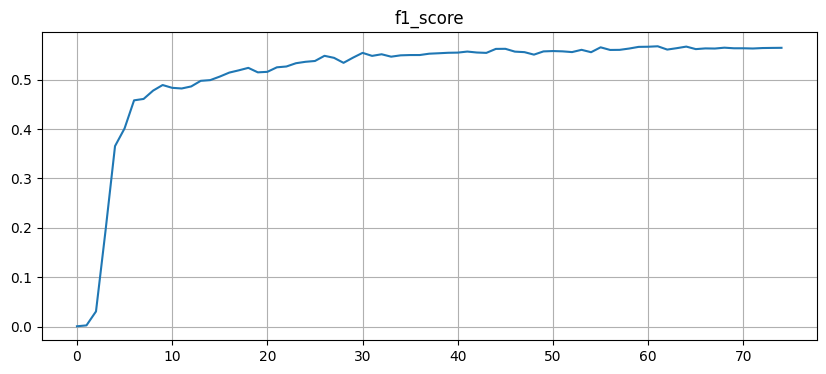

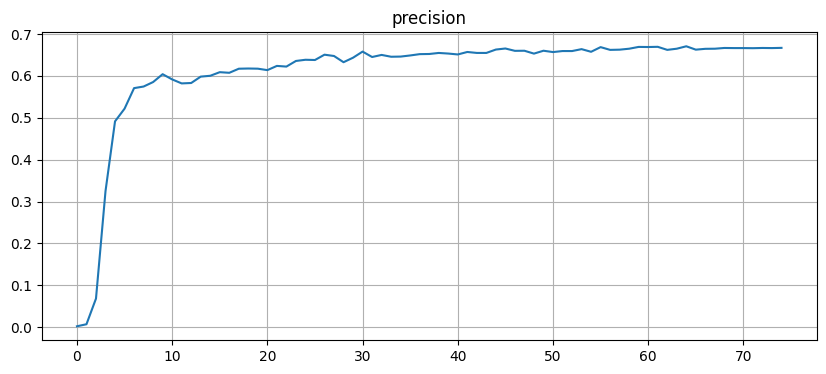

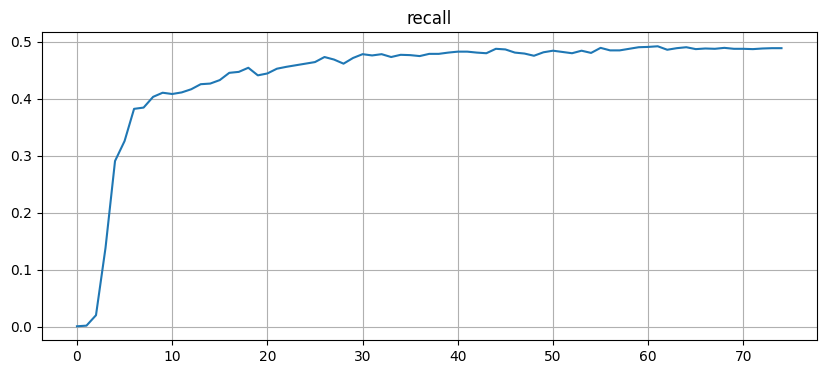

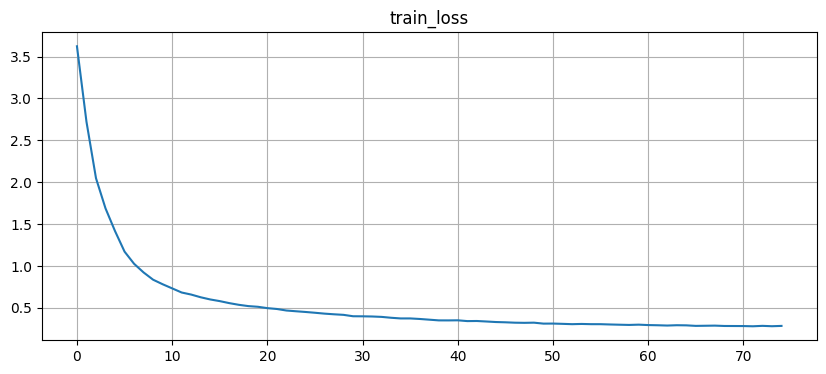

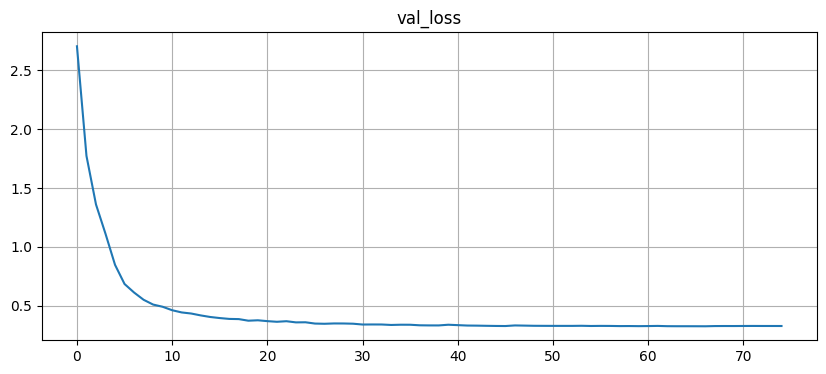

In [20]:
for i, (name, history) in enumerate (sorted (metrics.items ())):
    #plt.plot (1, len (metrics), i + 1)
    plt.figure (figsize = (10, 4))
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
    plt.show ()

In [21]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        outputs = model (input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        outputs = outputs.logits.argmax(-1)

        #print (outputs)
        print (tokenizer.batch_decode (labels))
        print (tokenizer.batch_decode (outputs))

        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        print (sanity_check (outputs, labels, to_print = True))

        break

OverflowError: can't convert negative int to unsigned

In [22]:


model.eval ()  # Устанавливаем модель в режим оценки
val_preds, val_labels = [], []

with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Validation: ', sanity_check (val_preds, val_labels))


val_preds, val_labels = [], []

with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Test: ', sanity_check (val_preds, val_labels))

100%|██████████| 21/21 [00:03<00:00,  5.58it/s]


Validation:  (0.6669190007570023, 0.48890122086570476, 0.5642010886967659)


100%|██████████| 22/22 [00:03<00:00,  5.74it/s]


Test:  (0.6484318016046682, 0.4855270344074276, 0.5552779512804497)


In [23]:

val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Validation wmax: ', sanity_check (val_preds, val_labels))


val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Test wmax: ', sanity_check (val_preds, val_labels))

100%|██████████| 21/21 [00:13<00:00,  1.56it/s]


Validation wmax:  (0.7249742002063984, 0.7796892341842397, 0.7513368983957219)


100%|██████████| 22/22 [00:14<00:00,  1.56it/s]


Test wmax:  (0.7156614292954891, 0.7711632987438558, 0.7423764458464774)


In [24]:
#model.save_pretrained('./coint_rut5small_finetune_ttsseed14_7722')
#tokenizer.save_pretrained('./coint_rut5small_finetune_ttsseed14_7722')

In [25]:
def raw_splitter (text, delimiters = ['...', '.', '?!', '?', '!']):

    delimiters_pattern = '|'.join (map (re.escape, delimiters))
    paragraphs = re.split (f'(?<=\n[ ]*)', text)
    
    sentences_with_indices = []
    current_start_index = 0

    for paragraph in paragraphs:

        sentences = re.split (f'(?<=[{delimiters_pattern}] )(?=[A-ZА-ЯЁ])', paragraph)#.strip ())

        for sentence in sentences:

            start_index = current_start_index
            end_index = start_index + len (sentence)

            sentences_with_indices.append ((sentence, (start_index, end_index)))

            current_start_index = end_index
    
    return sentences_with_indices

def one_finder (text, phrases):

    A = ahocorasick.Automaton ()
    
    for idx, phrase in enumerate (phrases):
        A.add_word (phrase, (idx, phrase))
    
    A.make_automaton ()
    
    found = []
    for end_index, (idx, phrase) in A.iter (text):
        start_index = end_index - len (phrase) + 1

        if start_index > 0 and text [start_index - 1].isalpha ():
            continue
        if end_index + 1 < len (text) and text [end_index + 1].isalpha ():
            continue

        found.append ((start_index, end_index + 1, phrase))
    
    return found

def answerer (text, term_set):
    sentences_w_ind = raw_splitter (text)

    answers = []
    for sentence, (start, end) in sentences_w_ind:
        found = one_finder (sentence, term_set)
        answers += [[item [0] + start, item [1] + start] for item in found]

    return answers

def comparator (pred, labl):

    pred = set ([tuple (item) for item in pred])
    labl = set ([tuple (item) for item in labl])

    true_positives = len (pred & labl)
    false_positives = len (pred - labl)
    false_negatives = len (labl - pred)

    return true_positives, false_positives, false_negatives

def metricator (preds, labels):

    tps_sum = 0
    fps_sum = 0
    fns_sum = 0 

    for i in range (len (labels)):

        true_positives, false_positives, false_negatives = comparator (preds [i], labels [i])

        tps_sum += true_positives   # Истинно положительные
        fps_sum += false_positives     # Ложноположительные
        fns_sum += false_negatives     # Ложноотрицательные

    precision = tps_sum / (tps_sum + fps_sum) if (tps_sum + fps_sum) > 0 else 0
    recall = tps_sum / (tps_sum + fns_sum) if (tps_sum + fns_sum) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score